In [1]:
import rebound as rb
import numpy as np

In [2]:
tt = 0.0761007811
aa = 0.22882
ee = 0.52087
ma = 1.0479
mb = 1.0208
#aa = 20.0
#ee = 0.0
#ma = 5.0
#mb = 5.0
print ((ma+mb)*tt**2)**(1./3.)

0.228818911026


The Kepler 34AB binary system features two G-type stars of 1.05 and 1.02 solar masses, separated by an average of 0.23 AU. They orbit each other every 28 days, with an eccentricity of 0.52.

In [3]:
sim = rb.Simulation()
sim.add(m=1.e-32)

We need to compute the periastron and apastron distances (rp & ra) between the stars. Once we have that, we can transform to a barycentric coordinate and find periapsi and apoapsi for each star relative to the barycenter.

In [4]:
rp = aa*(1-ee)
ra = aa*(1+ee)
rap = mb*rp/(ma+mb)
rbp = ma*rp/(ma+mb)
raa = mb*ra/(ma+mb)
rba = ma*ra/(ma+mb)

In [5]:
print rp,ra
print rap,rbp,raa,rba
print rap+rbp,raa+rba

0.1096345266 0.3480054734
0.0540991563558 0.0555353702442 0.171723298326 0.176282175074
0.1096345266 0.3480054734


Next we need the semimajor axes for each star in the barycentric frame of reference. With those, we can compute the periapsis velocity of each star. We'll start each star at its periapsis. The stars are always diagrammatically opposed, so we know they will both be at periapsis at the same time.

In [6]:
aaa = mb*aa/(ma+mb)
aab = ma*aa/(ma+mb)
vap = np.sqrt((1+ee)*mb/((1-ee)*aaa))
vbp = -np.sqrt((1+ee)*ma/((1-ee)*aab))
#vap = np.sqrt((ma+mb)/aaa*(1-ee**2))
#vbp = -np.sqrt((ma+mb)/aab*(1-ee**2))

In [7]:
print aaa,aab
print vap,vbp

0.112911227341 0.115908772659
5.35699364329 -5.35699364329


In [8]:
#sim.add(m=ma,x=rap,vy=vap)
#sim.add(m=mb,x=-rbp,vy=vbp)
sim.add(m=ma,a=aaa,e=ee,omega=np.pi,primary=sim.particles[0])
sim.add(m=mb,a=aab,e=ee,omega=0.,primary=sim.particles[0])

In [9]:
com=sim.calculate_com()
print com

<rebound.Particle object, id=0 m=2.0687 x=2.52690386455e-18 y=3.35601327635e-18 z=0.0 vx=-3.36700606086e-16 vy=-0.140365433426 vz=0.0>


Just to be safe, we explicitly tell the simulation that we'll be running in the center-of-momentum frame.

In [10]:
sim.move_to_com()

In [11]:
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)
for o in sim.calculate_orbits(barycentric=True): print o

<rebound.Orbit instance, a=0.0351255526271 e=0.540165273133 inc=0.0 Omega=0.0 omega=0.0 f=3.14159265359>
<rebound.Orbit instance, a=0.0384937488738 e=0.442711397796 inc=0.0 Omega=0.0 omega=3.14159265359 f=-3.14159265359>
<rebound.Orbit instance, a=0.0357150911447 e=0.51474221742 inc=0.0 Omega=0.0 omega=0.0 f=3.14159265359>
<rebound.Orbit instance, a=0.0377674747929 e=0.470454949627 inc=0.0 Omega=0.0 omega=3.14159265359 f=-3.14159265359>


Now we can add out planet, Kepler 34ABb. It has 0.22 Jupiter masses (about 70 earth masses), an inclination relative to Kepler 34AB of 0.4966 degrees, a semimajor axis of 1.09 AU, a period of 288 days or so, and an eccentricity of 0.182. 

In [12]:
ii = 0.4966*np.pi/180.
mp = 2.1e-4
ap = 1.0896
tp = 0.79075154
ep = 0.182
sim.add(m=mp,a=ap,e=ep,inc=ii,Omega=1.5*np.pi)

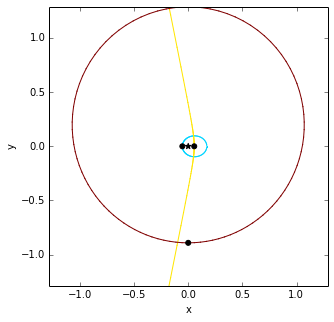

In [13]:
%matplotlib inline
fig=rb.OrbitPlot(sim,color=True)

In [14]:
sim.integrate(0.001)
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)

<rebound.Orbit instance, a=0.035293311512 e=0.543244612987 inc=0.0 Omega=-3.07555918446 omega=3.24155777876 f=-3.21011705907>
<rebound.Orbit instance, a=0.0386873993687 e=0.447268955148 inc=0.0 Omega=0.064142331858 omega=-3.00625391418 f=3.03958576639>


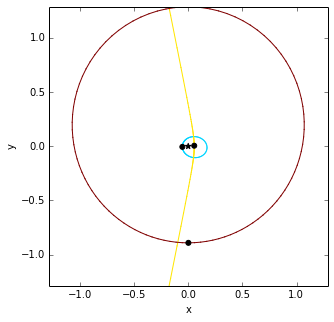

In [15]:
fig=rb.OrbitPlot(sim,color=True)

<rebound.Orbit instance, a=0.0503634064337 e=0.710115954357 inc=0.0 Omega=-2.54036074422 omega=3.73527105817 f=-3.53809730016>
<rebound.Orbit instance, a=0.0564935846829 e=0.673793522819 inc=0.0 Omega=0.575487699742 omega=-2.39893052681 f=2.62184824132>


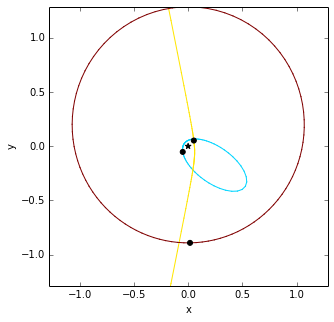

In [16]:
sim.integrate(0.01)
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)
fig=rb.OrbitPlot(sim,color=True)

<rebound.Orbit instance, a=-0.613261715465 e=1.0217112385 inc=1.10509969102e-07 Omega=-1.55448976721 omega=-2.70299341239 f=2.74256384248>
<rebound.Orbit instance, a=-0.339481742791 e=1.04139997939 inc=0.0 Omega=1.53697925732 omega=-2.60516983536 f=2.69486360098>


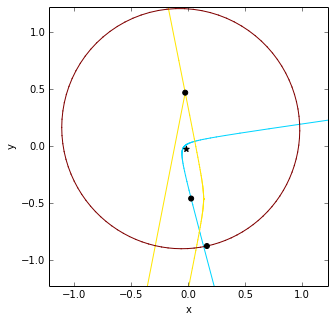

In [17]:
sim.integrate(0.1)
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)
fig=rb.OrbitPlot(sim,color=True)

<rebound.Orbit instance, a=-0.613261715465 e=1.0217112385 inc=1.10509969102e-07 Omega=-1.55448976721 omega=-2.70299341239 f=2.74256384248>
<rebound.Orbit instance, a=-0.339481742791 e=1.04139997939 inc=0.0 Omega=1.53697925732 omega=-2.60516983536 f=2.69486360098>


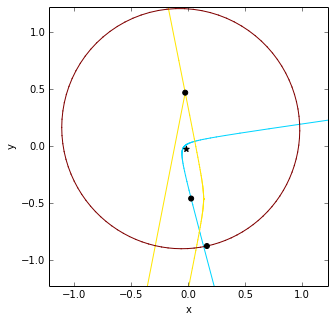

In [18]:
sim.integrate(0.1)
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)
fig=rb.OrbitPlot(sim,color=True)

<rebound.Orbit instance, a=-0.191417531727 e=1.12519336746 inc=1.33310854939e-05 Omega=-1.46745138648 omega=-2.56366280564 f=2.64332423187>
<rebound.Orbit instance, a=-0.156277091277 e=1.035400013 inc=1.01064592348e-07 Omega=1.69248621054 omega=-2.80894557104 f=2.87018194156>


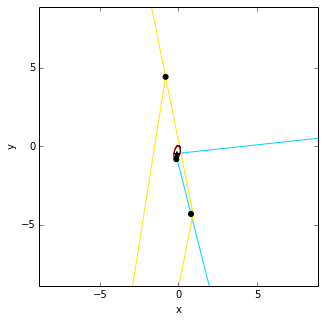

In [19]:
sim.integrate(1.0)
print sim.particles[1].calculate_orbit(primary=com)
print sim.particles[2].calculate_orbit(primary=com)
fig=rb.OrbitPlot(sim,color=True)

In [20]:
print sim.units

{'length': None, 'mass': None, 'time': None}
